In [244]:
"""The purpose of this tutorial is to introduce you to how:
   (1) compare feature-output data (from neurons or models) to behavioral data 
       using behavioral consistency metrics
   (2) compare neural network feature output to neural data using single-neuron
       regression metrics

This tutorial should be used in conjunction with the lecture:

    http://cs375.stanford.edu/lectures/lecture5_mapping_models_to_data.pdf

""";

In [200]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

#the above imports the plotting library matplotlib

In [201]:
#standard imports
import pymongo as pm
import numpy as np
import h5py
import scipy as sp
import scipy.stats as stats

#let's import the SVM classifier
from sklearn.svm import LinearSVC

#our own internal utility unctions
import metrics ; reload(metrics)
import cross_validation as cv; reload(cv)
import utils; reload(utils)
from utils import featurewise_norm, spearman_brown

# Mapping feature spaces to behavioral patterns

In [202]:
#where features can come from whatever -- models OR real neurons

In [203]:
"""
This first part of the notebook covers what is essentially a replication of the key findings in:

Majaj, Najib J., Ha Hong, Ethan A. Solomon, and James J. DiCarlo.
"Simple learned weighted sums of inferior temporal neuronal firing rates accurately 
predict human core object recognition performance." 
Journal of Neuroscience 35, no. 39 (2015): 13402-13418.

""";

In [204]:
#ok let's load the neural data 
Ventral_Dataset = h5py.File(NEURAL_DATA_PATH)

categories = Ventral_Dataset['image_meta']['category'][:]   #array of category labels for all images  --> shape == (5760,)
unique_categories = np.unique(categories)                #array of unique category labels --> shape == (8,)
objects = Ventral_Dataset['image_meta']['object_name'][:]   #array of object labels for all images --> shape == (5670,)
unique_objects = np.unique(objects)                      #array of unique object labels --> shape == (64,) 

objects_by_category = {c: np.unique(objects[categories == c]) 
                       for c in unique_categories}

Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]
IT_NEURONS = Ventral_Dataset['neural_meta']['IT_NEURONS']
V4_NEURONS = Ventral_Dataset['neural_meta']['V4_NEURONS']
V4_Neural_Data = Neural_Data[:, V4_NEURONS]
IT_Neural_Data = Neural_Data[:, IT_NEURONS]

var_level = Ventral_Dataset['image_meta']['variation_level'][:]

#use numpy recarray object to store metadata 
meta_array = np.core.records.fromarrays(Ventral_Dataset['image_meta'].values(),
                                        names=Ventral_Dataset['image_meta'].keys())

## Human Behavioral Dataset

In [205]:
#and also let's load some behavioral data
HUMAN_DATA_PATH = "/mnt/data3/yamins/visual/human_behavior.hdf5"
Behavioral_Dataset = h5py.File(HUMAN_DATA_PATH)

In [206]:
#let's explore the behavorial data a little
Behavioral_Dataset.keys()
#OK -- each of these 9 keys corresponds to an experiment
#humans were asked to do 8-way alternative forced choice (AFC) tasks
#one of these experiments (Basic_categorization) is where the humans
#were choosing the *category* of object shown in an image out of the 8
#unique categories.  For the other 8 tasks, the humans were supposed to 
#indicate which *object* was shown, within the indicated class.  E.g. 
#Animals_identification meant that the idea was identify which of 8 
#animals was shown in the image.

[u'Animals_identification',
 u'Basic_categorization',
 u'Boats_identification',
 u'Cars_identification',
 u'Chairs_identification',
 u'Faces_identification',
 u'Fruits_identification',
 u'Planes_identification',
 u'Tables_identification']

In [207]:
#What are the keys within each experiment?
Behavioral_Dataset['Basic_categorization'].keys()
#ok there appear to be things related to the individuals choice ('chosen'), the 
#ground true ("actual"), the reaction time, and image variation level

[u'actual', u'chosen', u'image_id', u'reaction_time', u'variation_level']

In [208]:
#what's in each of these keys?
Behavioral_Dataset['Basic_categorization']['actual']
#ah, so "actual" is an array dataset

<HDF5 dataset "actual": shape (80, 192), type "|S7">

In [209]:
#what are its dimensions?
Behavioral_Dataset['Basic_categorization']['actual'].dims.keys()
#ok, apparently subect x trial

[<"subject" dimension 0 of HDF5 dataset at 139808849006960>,
 <"trial" dimension 1 of HDF5 dataset at 139808849006960>]

In [210]:
#what do the actual labels look like? 
Behavioral_Dataset['Basic_categorization']['actual'][0][:10]
#ok they're category labels, that's reasonable if this was a 
#categorization task

array(['Chairs', 'Boats', 'Fruits', 'Faces', 'Cars', 'Planes', 'Chairs',
       'Cars', 'Fruits', 'Animals'], dtype='|S7')

In [211]:
Behavioral_Dataset['Basic_categorization']['chosen'][0][:10]

array(['Chairs', 'Boats', 'Fruits', 'Faces', 'Cars', 'Planes', 'Chairs',
       'Cars', 'Fruits', 'Animals'], dtype='|S7')

In [212]:
Behavioral_Dataset['Animals_identification']['chosen'][0][:10]

array(['hedgehog', 'GORILLA', 'bear', 'blCow', 'blCow', 'ELEPHANT_M',
       'bear', 'GORILLA', 'breed_pug', 'breed_pug'], dtype='|S10')

In [213]:
#ok so we see that for each experiment, we have data arrays for 
#"actual", "chosen", "reaction_time" and "variation_level" among things
#these arrays of of the form of (subject, trial) for different subjects and trials
#within that subject

In [214]:
#how good are the subjects at these tasks?
chosen = Behavioral_Dataset['Basic_categorization']['chosen'][:]
actual = Behavioral_Dataset['Basic_categorization']['actual'][:]
percent_correct = (chosen == actual).mean() * 100
print('The subjects achieved mean accuracy of %.2f%% on basic categorization' % percent_correct)

The subjects achieved mean accuracy of 88.38% on basic categorization


In [215]:
#ok let's get the confusion matrices for each part of the dat
#by variation level for all experiments

expnames = [('Basic_categorization', 'category')] + \
            [(c + '_identification', 'obj') for c in unique_categories]
    
human_confmats = {}
for expname, exp_goal in expnames:
    if 'Basic' in expname:
        ucats = unique_categories
    else:
        catn = expname.split('_')[0]
        ucats = objects_by_category[catn]
    preds = Behavioral_Dataset[expname]['chosen']
    actuals = Behavioral_Dataset[expname]['actual']
    vls = Behavioral_Dataset[expname]['variation_level']
    cms = np.array([metrics.get_confusion_matrix(p, a, ucats) for p, a in zip(preds, actuals)])
    human_confmats[(expname, 'all')] = cms
    for v in ['V0', 'V3', 'V6']:
        cms = np.array([metrics.get_confusion_matrix(p[vl==v], a[vl==v], ucats) 
                             for p, a, vl in zip(preds, actuals, vls)])
        human_confmats[(expname, v)] = cms
                     

In [216]:
cmat = human_confmats[('Basic_categorization', 'V0')]
cmat.shape
#ok we've gathered the confusion matrices so that the 0th axis 
#is the subject dimension

(80, 8, 8)

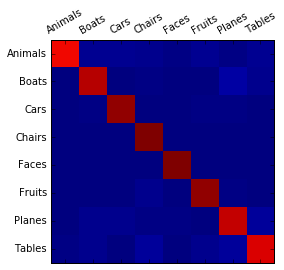

In [217]:
#What does the confusion matrix look like? 
plt.matshow(cmat.mean(0))
plt.xticks(range(8), unique_categories, rotation=30);
plt.yticks(range(8), unique_categories);

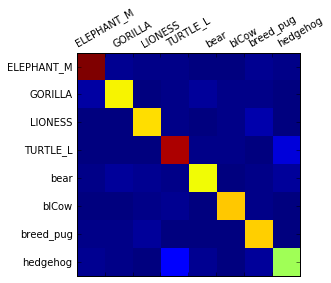

In [218]:
#ok, subordinate identification at V3 is harder:
cmat = human_confmats[('Animals_identification', 'V3')]
plt.matshow(cmat.mean(0))
plt.xticks(np.arange(8)+.5, objects_by_category['Animals'], rotation=30);
plt.yticks(range(8), objects_by_category['Animals']);

### Split-half reliability of human data

In [219]:
def get_dprimes(keys, results=None, confmats=None):
    """utility function for extracting dprimes from results
    """
    dprimes = []
    for k in keys:
        if confmats is None:
            expname, vl = k
            cmat = results[expname][vl][0]['test']['confusion_matrices']
        else:
            cmat = confmats[k]

        dp = metrics.dprime_confmat(cmat.mean(0))
        dprimes.extend(dp)
    return dprimes

In [220]:
keys = human_confmats.keys()
d_human = get_dprimes(keys, confmats=human_confmats)

len(d_human)
#There are 288 overall task points here

288

In [221]:
#what do the d-prime values look like? 
print(np.max(d_human), np.min(d_human))
d_human[:10]

(10.0, -0.2775379463332328)


[3.2610207344528197,
 2.8027049409436184,
 2.705685608005872,
 4.01156348109842,
 3.7612749373734005,
 4.189169164717839,
 3.262731147300626,
 4.343182195276393,
 2.6812870164452627,
 2.1244318651375025]

In [222]:
def idfunc(x):
    return x

def pearsonr(a, b):
    return stats.pearsonr(a, b)[0]

def spearmanr(a, b):
    return stats.spearmanr(a, b)[0]

def split_half_correlation(datas_by_trial,
                           num_splits,
                           aggfunc=idfunc,
                           statfunc=pearsonr):
    """
    Similar to split-half calculation from lecture 2, 
    but now allowing various aggregation and statistical comparison 
    functions
    """
        
    random_number_generator = np.random.RandomState(seed=0)

    corrvals = []
    for split_index in range(num_splits):
        stats1 = []
        stats2 = []
        for data in datas_by_trial:
            #get total number of trials
            num_trials = data.shape[0]

            #construct a new permutation of the trial indices
            perm = random_number_generator.permutation(num_trials)

            #take the first num_trials/2 and second num_trials/2 pieces of the data
            first_half_of_trial_indices = perm[:num_trials / 2]
            second_half_of_trial_indices = perm[num_trials / 2: num_trials]

            #mean over trial dimension
            s1 = aggfunc(data[first_half_of_trial_indices].mean(axis=0))
            s2 = aggfunc(data[second_half_of_trial_indices].mean(axis=0))
            stats1.extend(s1)
            stats2.extend(s2)
        
        #compute the correlation between the means
        corrval = statfunc(np.array(stats1), 
                           np.array(stats2))
        #add to the list
        corrvals.append(corrval)
        
    return spearman_brown(np.array(corrvals), 2)

In [223]:
#Ok so oftentimes the reliability is pretty good
correlations = split_half_correlation(
                       [human_confmats[('Basic_categorization', 'V3')]],
                       num_splits=100, 
                       aggfunc=metrics.dprime_confmat)
correlations.mean()

0.9667419544279628

In [224]:
#sometimes it's a bit less
correlations = split_half_correlation(
                       [human_confmats[('Boats_identification', 'V3')]],
                       num_splits=100, 
                       aggfunc=metrics.dprime_confmat)
correlations.mean()

0.6479620985097206

In [225]:
#obviously pretty poor for a few especially confusing tasks
correlations = split_half_correlation(
                       [human_confmats[('Faces_identification', 'V0')]],
                       num_splits=500, 
                       aggfunc=metrics.dprime_confmat)
correlations.mean()

-0.44250655513222925

In [226]:
def rsquared(v1, v2):
    w, b, r, p, ser = stats.linregress(v1, v2)
    return r**2

In [227]:
correlations = split_half_correlation(
                       [human_confmats[('Basic_categorization', 'V3')]],
                       num_splits=100, 
                       aggfunc=metrics.dprime_confmat,
                       statfunc=rsquared)
correlations.mean()

0.9336604420815234

In [228]:
def get_split_half_from_cmatdict(confmat_dict, ks):
    #compute reliability using correlation metric
    corrvals = split_half_correlation([confmat_dict[k] for k in ks],
                       num_splits=100, 
                       aggfunc=metrics.dprime_confmat)
    
    #compute reliabiliy using rsquared metric
    rsquareds = split_half_correlation([confmat_dict[k] for k in ks],
                       num_splits=100, 
                       aggfunc=metrics.dprime_confmat,
                       statfunc=rsquared)
    return corrvals.mean(), rsquareds.mean()

In [229]:
#ok so let's look dprime reliabilities
#across many tasks
human_splithalf = get_split_half_from_cmatdict(human_confmats, keys) 

In [230]:
#correlation split half is pretty high
human_splithalf[0]

0.9053428877324445

In [231]:
#rsquared split half is consistent
human_splithalf[1]

0.8125547052549716

## Getting Classifier Decoding Results

In [232]:
pretty_good_cval = 1e-3
var_levels = ['all', 'V0', 'V3', 'V6']
        
def get_splits_and_labels(expname, exp_goal, vl):
    num_test = 10
    if vl == 'V0':
        num_test = 7
        num_train = 10 - num_test
    elif vl in ['V3', 'V6']:
        num_train = 40 - num_test
    else:
        num_train = 90 - num_test
    if exp_goal == 'category':
        if vl == 'all':
            train_filter = None
            test_filter = None
        else:
            train_filter = lambda x: (x['variation_level'] == vl)
            test_filter = lambda x: (x['variation_level'] == vl)

        labels = meta_array['category']
    else:
        catn = expname.split('_')[0]
        if vl == 'all':
            train_filter = lambda x: (x['category'] == catn)
            test_filter = lambda x: (x['category'] == catn)
        else:
            train_filter = lambda x: (x['variation_level'] == vl) and (x['category'] == catn)
            test_filter = lambda x: (x['variation_level'] == vl) and (x['category'] == catn)

        labels = meta_array['object_name']
        
    splits = cv.get_splits(metadata=meta_array, 
                           split_by_func=lambda x: x['object_name'],  #we're balancing splits by object
                           num_splits=5,  
                           num_per_class_test=num_test,  
                           num_per_class_train=num_train,
                           train_filter=train_filter,
                           test_filter=test_filter
                           )
   
    return splits, labels
    


In [233]:
def tabulate_results(features, model_type,
                     model_args=None, gridcv_params=None,
                     toprint=False):
    """
    Trains and gets results for whatever desired model type
    for all the different tasks in the task battery
    """
    results = {}
    for expname, exp_goal in expnames:
        results[expname] = {}
        for vl in var_levels:
            if toprint:
                print('Getting results for %s %s' % (expname, vl))
            splits, labels = get_splits_and_labels(expname, exp_goal, vl)
            results[expname][vl] = cv.train_and_test_scikit_classifier(features=features, 
                                         labels=labels,
                                         splits=splits,
                                         model_class=model_type,
                                         model_args=model_args,
                                         gridcv_params=gridcv_params)
            if toprint:
                acc = neural_results[expname][vl][0]['test']['mean_accuracy'] * 100
                print('Mean accuracy: %.2f' % acc)
    return results

def get_split_half_from_resultdict(res_dict, ks):
    cmatdict = {(en, vl): res_dict[en][vl][0]['test']['confusion_matrices'] for en, vl in ks}
    return get_split_half_from_cmatdict(cmatdict, ks)

In [270]:
import minimum_distance_classifier as mdc

In [282]:
neural_results_MDC = tabulate_results(Neural_Data, 
                                      mdc.MinimumDistanceClassifier,
                                      toprint=True)

IT_neural_results_MDC = tabulate_results(IT_Neural_Data,
                                         mdc.MinimumDistanceClassifier)                                    
        
V4_neural_results_MDC = tabulate_results(V4_Neural_Data,
                                         mdc.MinimumDistanceClassifier)                                    


Getting results for Basic_categorization all
Mean accuracy: 74.38
Getting results for Basic_categorization V0
Mean accuracy: 90.27
Getting results for Basic_categorization V3
Mean accuracy: 85.03
Getting results for Basic_categorization V6
Mean accuracy: 61.44
Getting results for Animals_identification all
Mean accuracy: 69.50
Getting results for Animals_identification V0
Mean accuracy: 83.21
Getting results for Animals_identification V3
Mean accuracy: 75.50
Getting results for Animals_identification V6
Mean accuracy: 52.25
Getting results for Boats_identification all
Mean accuracy: 57.50
Getting results for Boats_identification V0
Mean accuracy: 92.14
Getting results for Boats_identification V3
Mean accuracy: 55.50
Getting results for Boats_identification V6
Mean accuracy: 36.50
Getting results for Cars_identification all
Mean accuracy: 32.00
Getting results for Cars_identification V0
Mean accuracy: 61.79
Getting results for Cars_identification V3
Mean accuracy: 37.00
Getting results 

In [152]:
neural_results = tabulate_results(Neural_Data, 
                                  LinearSVC, 
                                  {'C': pretty_good_cval},
                                 toprint=True)

IT_neural_results = tabulate_results(IT_Neural_Data,
                                     LinearSVC,
                                     {'C': pretty_good_cval})                                    
        
V4_neural_results = tabulate_results(V4_Neural_Data,
                                     LinearSVC,
                                     {'C': pretty_good_cval})                                    


Getting results for Basic_categorization all
Mean accuracy: 74.38
Getting results for Basic_categorization V0
Mean accuracy: 90.27
Getting results for Basic_categorization V3
Mean accuracy: 85.03
Getting results for Basic_categorization V6
Mean accuracy: 61.44
Getting results for Animals_identification all
Mean accuracy: 69.50
Getting results for Animals_identification V0
Mean accuracy: 83.21
Getting results for Animals_identification V3
Mean accuracy: 75.50
Getting results for Animals_identification V6
Mean accuracy: 52.25
Getting results for Boats_identification all
Mean accuracy: 57.50
Getting results for Boats_identification V0
Mean accuracy: 92.14
Getting results for Boats_identification V3
Mean accuracy: 55.50
Getting results for Boats_identification V6
Mean accuracy: 36.50
Getting results for Cars_identification all
Mean accuracy: 32.00
Getting results for Cars_identification V0
Mean accuracy: 61.79
Getting results for Cars_identification V3
Mean accuracy: 37.00
Getting results 

In [246]:
from sklearn.linear_model import LogisticRegression

In [247]:
neural_results_LR = tabulate_results(Neural_Data,
                                     LogisticRegression,
                                     {'solver': 'saga',
                                            'C': 1e-2, 
                                            'multi_class': 'multinomial'})

IT_neural_results_LR = tabulate_results(IT_Neural_Data,
                                     LogisticRegression,
                                     {'solver': 'saga',
                                            'C': 1e-2, 
                                            'multi_class': 'multinomial'},
                                     toprint=False)                                    
        
V4_neural_results_LR = tabulate_results(V4_Neural_Data,
                                     LogisticRegression,
                                     {'solver': 'saga',
                                            'C': 1e-2, 
                                            'multi_class': 'multinomial'},
                                       toprint=False)                                    


Getting results for Basic_categorization all
Mean accuracy: 75.09
Getting results for Basic_categorization V0


/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Mean accuracy: 88.12
Getting results for Basic_categorization V3
Mean accuracy: 84.66
Getting results for Basic_categorization V6
Mean accuracy: 61.06
Getting results for Animals_identification all
Mean accuracy: 66.75
Getting results for Animals_identification V0
Mean accuracy: 82.50
Getting results for Animals_identification V3
Mean accuracy: 72.00
Getting results for Animals_identification V6
Mean accuracy: 48.25
Getting results for Boats_identification all
Mean accuracy: 56.00
Getting results for Boats_identification V0
Mean accuracy: 91.79
Getting results for Boats_identification V3
Mean accuracy: 53.25
Getting results for Boats_identification V6
Mean accuracy: 36.25
Getting results for Cars_identification all
Mean accuracy: 30.50
Getting results for Cars_identification V0
Mean accuracy: 60.71
Getting results for Cars_identification V3
Mean accuracy: 33.25
Getting results for Cars_identification V6
Mean accuracy: 14.50
Getting results for Chairs_identification all
Mean accuracy: 5

In [306]:
from sklearn.svm import SVC

In [311]:
neural_results_RBF = tabulate_results(Neural_Data,
                                     SVC,
                                     {'C': pretty_good_cval,
                                      'kernel': 'rbf'}, 
                                      toprint=True)

IT_neural_results_RBF = tabulate_results(IT_Neural_Data,
                                     SVC,
                                     {'C': pretty_good_cval})

V4_neural_results_RBF = tabulate_results(V4_Neural_Data,
                                     SVC,
                                     {'C': pretty_good_cval})


Getting results for Basic_categorization all
Mean accuracy: 74.38
Getting results for Basic_categorization V0
Mean accuracy: 90.27
Getting results for Basic_categorization V3
Mean accuracy: 85.03
Getting results for Basic_categorization V6
Mean accuracy: 61.44
Getting results for Animals_identification all
Mean accuracy: 69.50
Getting results for Animals_identification V0
Mean accuracy: 83.21
Getting results for Animals_identification V3
Mean accuracy: 75.50
Getting results for Animals_identification V6
Mean accuracy: 52.25
Getting results for Boats_identification all
Mean accuracy: 57.50
Getting results for Boats_identification V0
Mean accuracy: 92.14
Getting results for Boats_identification V3
Mean accuracy: 55.50
Getting results for Boats_identification V6
Mean accuracy: 36.50
Getting results for Cars_identification all
Mean accuracy: 32.00
Getting results for Cars_identification V0
Mean accuracy: 61.79
Getting results for Cars_identification V3
Mean accuracy: 37.00
Getting results 

## Actually make the comparison

In [463]:
def analyze_relationship(keys):
    #get the dprimes from the trained classifiers
    d_neural = get_dprimes(keys, results=neural_results)
    d_it = get_dprimes(keys, results=IT_neural_results)
    d_v4 = get_dprimes(keys, results=V4_neural_results)
    d_neural_CV = get_dprimes(keys, results=neural_results_CV)
    d_it_CV = get_dprimes(keys, results=IT_neural_results_CV)
    d_v4_CV = get_dprimes(keys, results=V4_neural_results_CV)
    d_neural_LR = get_dprimes(keys, results=neural_results_LR)
    d_it_LR = get_dprimes(keys, results=IT_neural_results_LR)
    d_v4_LR = get_dprimes(keys, results=V4_neural_results_LR)
    d_neural_MDC = get_dprimes(keys, results=neural_results_MDC)
    d_it_MDC = get_dprimes(keys, results=IT_neural_results_MDC)
    d_v4_MDC = get_dprimes(keys, results=V4_neural_results_MDC)
    d_neural_RBF = get_dprimes(keys, results=neural_results_RBF)
    d_it_RBF = get_dprimes(keys, results=IT_neural_results_RBF)
    d_v4_RBF = get_dprimes(keys, results=V4_neural_results_RBF)
    
    #get the denominator (noise estimate) from the trained classifiers
    neural_splithalf = get_split_half_from_resultdict(neural_results, keys) 
    it_neural_splithalf = get_split_half_from_resultdict(IT_neural_results, keys) 
    v4_neural_splithalf = get_split_half_from_resultdict(V4_neural_results, keys) 
    neural_splithalf_CV = get_split_half_from_resultdict(neural_results_CV, keys) 
    it_neural_splithalf_CV = get_split_half_from_resultdict(IT_neural_results_CV, keys) 
    v4_neural_splithalf_CV = get_split_half_from_resultdict(V4_neural_results_CV, keys) 
    neural_splithalf_LR = get_split_half_from_resultdict(neural_results_LR, keys) 
    it_neural_splithalf_LR = get_split_half_from_resultdict(IT_neural_results_LR, keys) 
    v4_neural_splithalf_LR = get_split_half_from_resultdict(V4_neural_results_LR, keys) 
    neural_splithalf_MDC = get_split_half_from_resultdict(neural_results_MDC, keys) 
    it_neural_splithalf_MDC = get_split_half_from_resultdict(IT_neural_results_MDC, keys) 
    v4_neural_splithalf_MDC = get_split_half_from_resultdict(V4_neural_results_MDC, keys) 
    neural_splithalf_RBF = get_split_half_from_resultdict(neural_results_RBF, keys) 
    it_neural_splithalf_RBF = get_split_half_from_resultdict(IT_neural_results_RBF, keys) 
    v4_neural_splithalf_RBF = get_split_half_from_resultdict(V4_neural_results_RBF, keys) 

    #get the dprimes from the humans
    d_human = get_dprimes(keys, confmats=human_confmats)
    #get the denominator (noise estimate) from the humans
    human_splithalf = get_split_half_from_cmatdict(human_confmats, keys) 
    
    def do_subplot(dvec, shalf, tag):
        plt.scatter(dvec, d_human)
        #the numerator of the noise-corrected final comparison value
        corrval = stats.pearsonr(dvec, d_human)[0]
        corrected_corrval = corrval / np.sqrt(human_splithalf[0] * \
                                              shalf[0])
        rsquared_val = rsquared(np.array(dvec), np.array(d_human))   
        corrected_rsquared = rsquared_val / np.sqrt(human_splithalf[1] * \
                                              shalf[1])
        plt.title('Human/%s\nCorrected Correlation  = %.2f'
                  '\nCorrected R-squared  = %.2f' % 
                      (tag, corrected_corrval, corrected_rsquared))
        plt.xlabel('%s d-prime' % tag); 
        plt.ylabel('Human d-prime')
        
    
    plt.figure(figsize=(16, 20))
    plt.subplot(4, 3, 1)
    do_subplot(d_neural, neural_splithalf, 'all neu-SVM')
    
    plt.subplot(4, 3, 2)
    do_subplot(d_it, it_neural_splithalf,'IT-SVM')

    plt.subplot(4, 3, 3)
    do_subplot(d_v4, it_neural_splithalf, 'V4-SVM')

    plt.subplot(4, 3, 4)
    do_subplot(d_neural_LR, neural_splithalf_LR, 'all neu-Logis. Regr.')

    plt.subplot(4, 3, 5)
    do_subplot(d_it_LR, it_neural_splithalf_LR, 'IT-Logis. Regr.')

    plt.subplot(4, 3, 6)
    do_subplot(d_v4_LR, v4_neural_splithalf_LR, 'V4-Logis. Regr.')

    plt.subplot(4, 3, 7)
    do_subplot(d_neural_MDC, neural_splithalf_MDC, 'all neu-Corr')
    
    plt.subplot(4, 3, 8)
    do_subplot(d_it_MDC, it_neural_splithalf_MDC, 'IT-Corr')
 
    plt.subplot(4, 3, 9)
    do_subplot(d_v4_MDC, v4_neural_splithalf_MDC, 'V4-COrr')

    plt.subplot(4, 3, 10)
    do_subplot(d_neural_RBF, neural_splithalf_RBF, 'all neu-RBF')

    plt.subplot(4, 3, 11)
    do_subplot(d_it_RBF, it_neural_splithalf_RBF, 'IT-RBF')

    plt.subplot(4, 3, 12)
    do_subplot(d_v4_RBF, v4_neural_splithalf_RBF, 'V4-RBF')
    
    plt.subplots_adjust(hspace=.4)

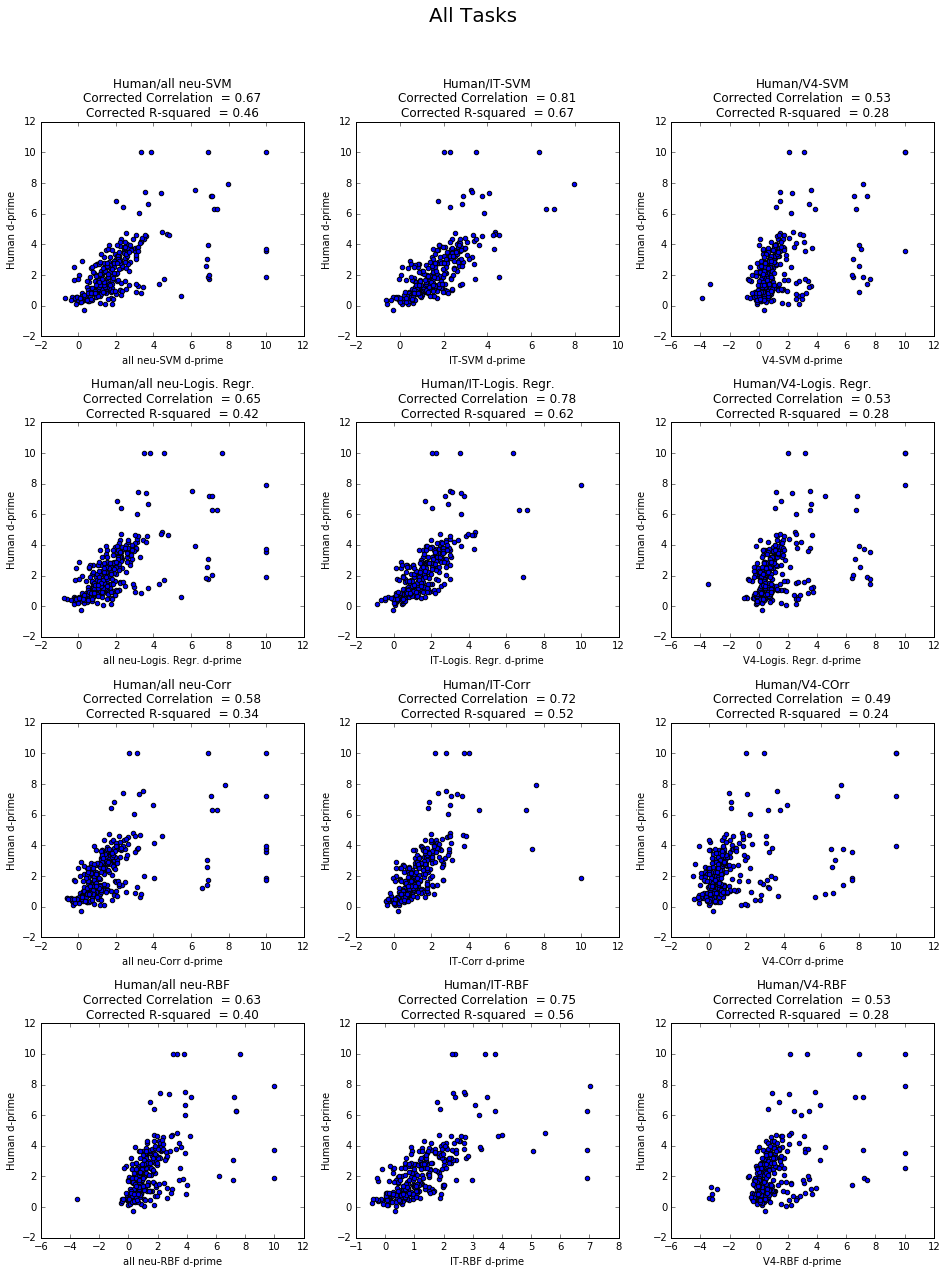

In [464]:
keys = human_confmats.keys()
analyze_relationship(keys)
plt.suptitle('All Tasks', fontsize=20)

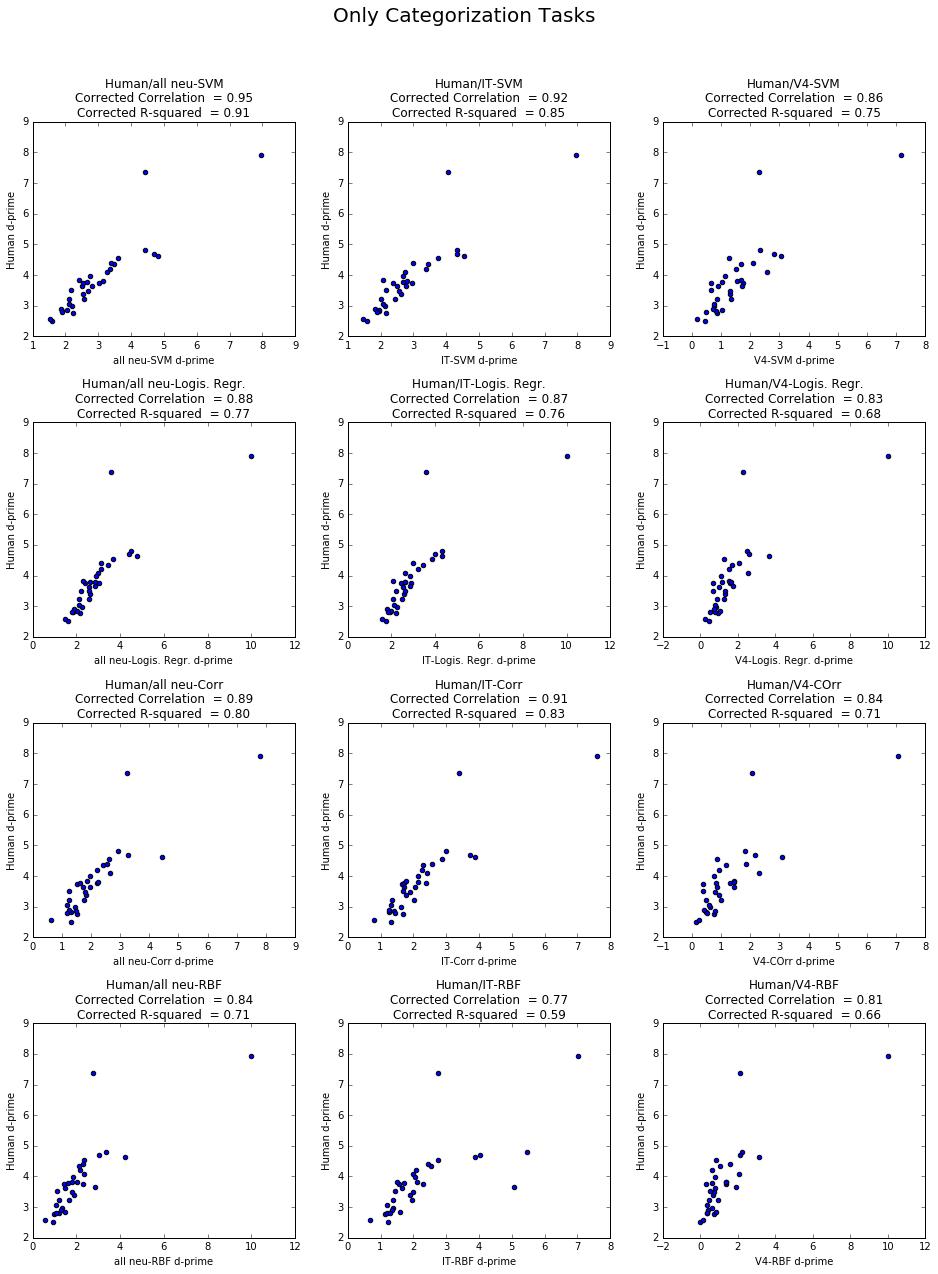

In [465]:
#Only for basic-level categorization tasks 
keys = [x for x in human_confmats.keys() if 'Basic' in x[0]]
analyze_relationship(keys)
plt.suptitle('Only Categorization Tasks', fontsize=20)

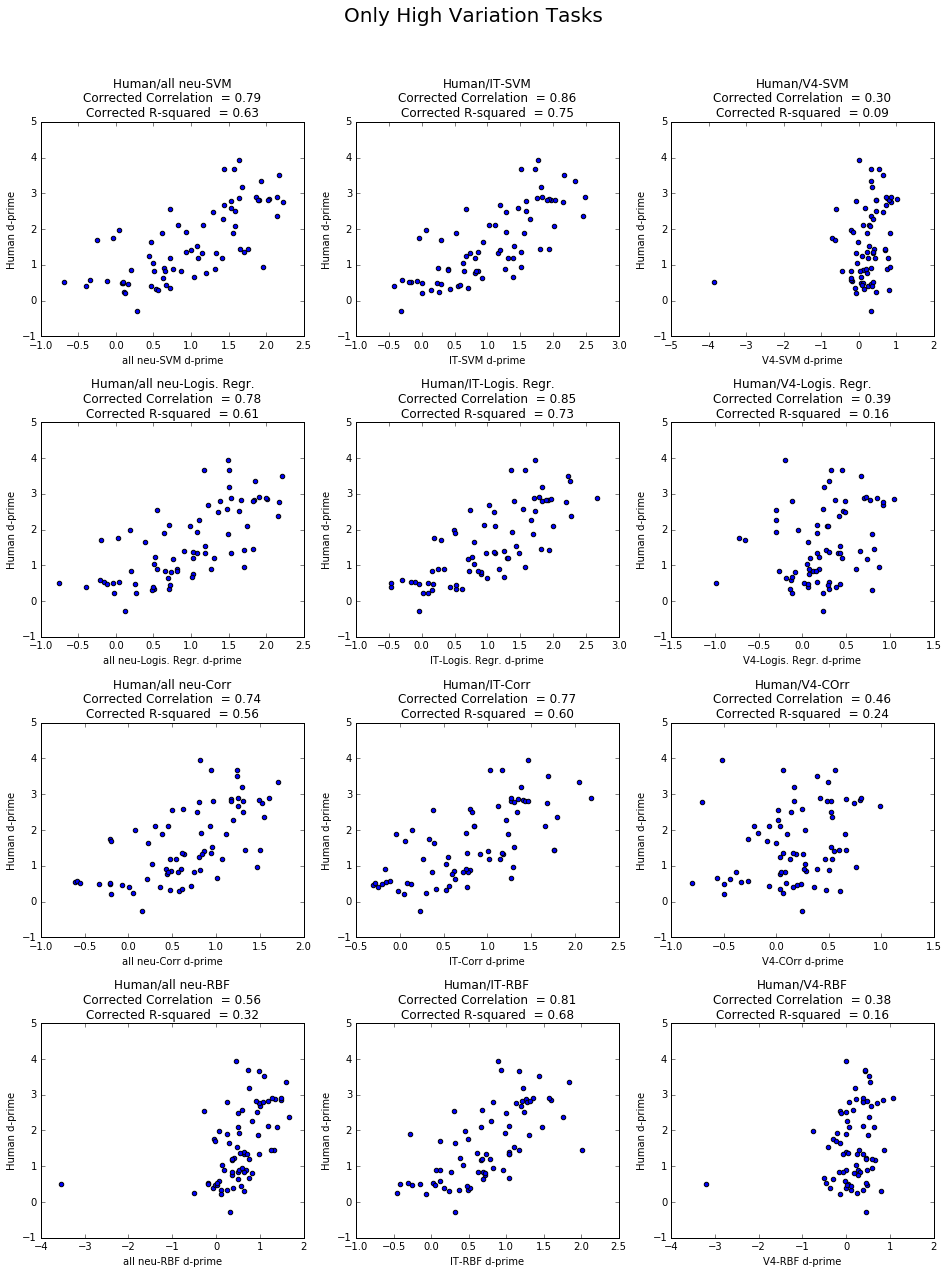

In [466]:
keys = [x for x in human_confmats.keys() if x[1] in ['V6']]
analyze_relationship(keys)
plt.suptitle('Only High Variation Tasks', fontsize=20)

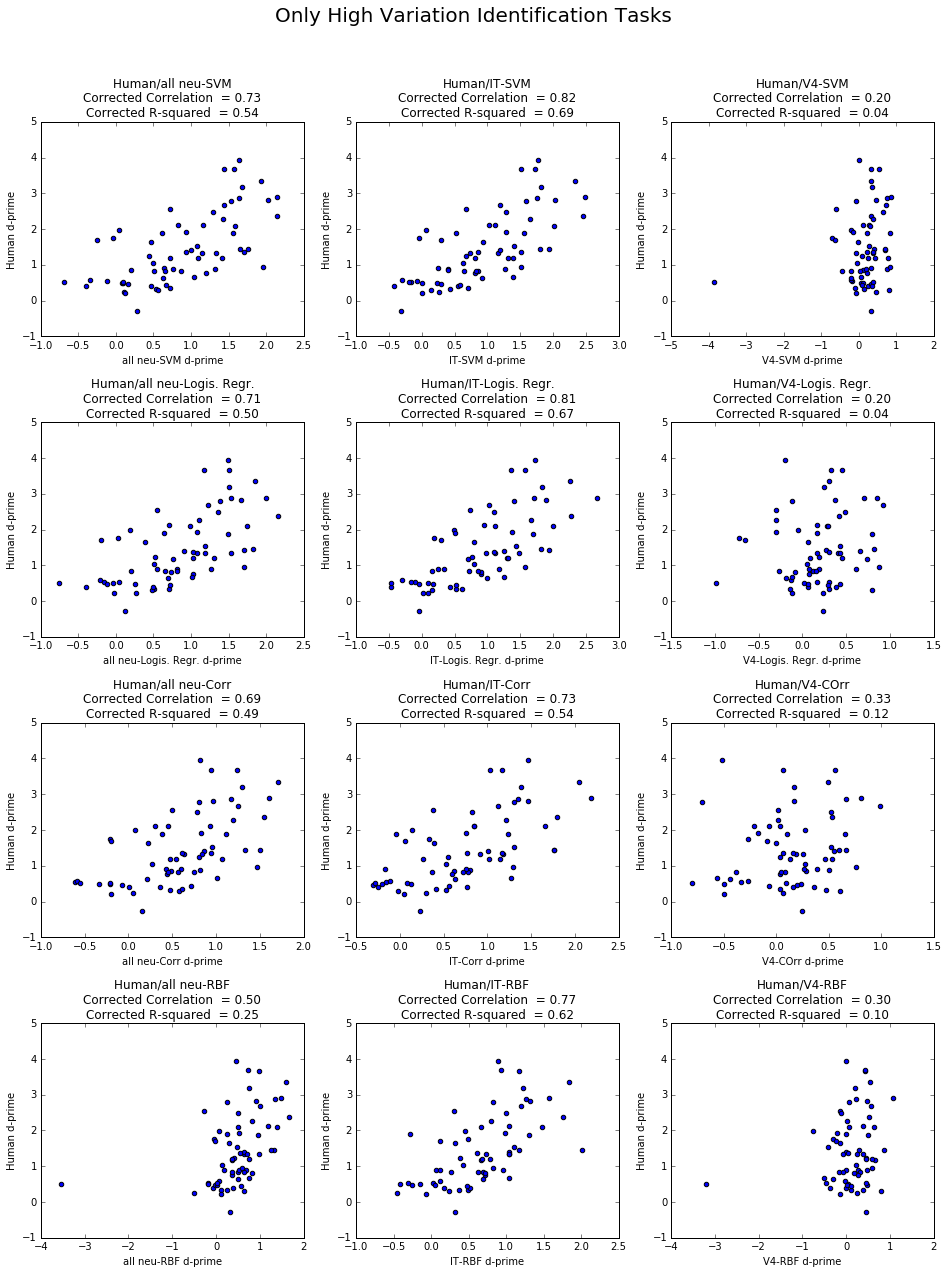

In [467]:
keys = [x for x in human_confmats.keys() if x[1] in ['V6'] and 
        'Basic' not in x[0]]
analyze_relationship(keys)
plt.suptitle('Only High Variation Identification Tasks', fontsize=20)

In [ ]:
cvals = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 
         1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2,
         1e3, 1e4, 1e5, 1e6, 1e7, 1e8]

neural_results_CV = tabulate_results(Neural_Data,                                   LinearSVC, 
                                     gridcv_params={'C': cvals},
                                     toprint=True)

IT_neural_results_CV = tabulate_results(IT_Neural_Data,
                                     LinearSVC,
                                     gridcv_params={'C': cvals})                                   
        
V4_neural_results_CV = tabulate_results(V4_Neural_Data,
                                        LinearSVC,
                                        gridcv_params={'C': cvals})                                  


Getting results for Basic_categorization all
Mean accuracy: 74.38
Getting results for Basic_categorization V0
Mean accuracy: 90.27
Getting results for Basic_categorization V3
Mean accuracy: 85.03
Getting results for Basic_categorization V6
Mean accuracy: 61.44
Getting results for Animals_identification all
Mean accuracy: 69.50
Getting results for Animals_identification V0
Mean accuracy: 83.21
Getting results for Animals_identification V3
Mean accuracy: 75.50
Getting results for Animals_identification V6
Mean accuracy: 52.25
Getting results for Boats_identification all
Mean accuracy: 57.50
Getting results for Boats_identification V0
Mean accuracy: 92.14
Getting results for Boats_identification V3
Mean accuracy: 55.50
Getting results for Boats_identification V6
Mean accuracy: 36.50
Getting results for Cars_identification all
Mean accuracy: 32.00
Getting results for Cars_identification V0
Mean accuracy: 61.79
Getting results for Cars_identification V3
Mean accuracy: 37.00
Getting results 

# TFUtils-based regression from trained deep network

### loading the neural data

In [1]:
#standard imports
import os
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = ''

import pymongo as pm
import numpy as np
import h5py
import scipy as sp
import scipy.stats as stats

#let's import PLS Regression routine from scikit
from sklearn.cross_decomposition import PLSRegression

#our own internal utility unctions
import metrics ; reload(metrics)
import cross_validation as cv; reload(cv)
import utils; reload(utils)
from utils import featurewise_norm, spearman_brown

import neural_data

import tfutils.model_tool as tf_model_tool

In [2]:
sess = tf.Session()

In [3]:
NEURAL_DATA_PATH = "/home/chengxuz/Class/psych253_2018/data/ventral_neural_data.hdf5"


In [4]:
def rsquared(predicted, actual):
    """The "rsquared" metric
    """
    a_mean = actual.mean()
    num = np.linalg.norm(actual - predicted)**2
    denom = np.linalg.norm(actual - a_mean)**2
    return 1 - num / denom

In [7]:
NEURAL_DATA_PATH = "/home/chengxuz/Class/psych253_2018/data/ventral_neural_data.hdf5"


In [5]:
def evaluate_regression_results(predicted, actual):
    """computing various useful metrics for regression results
    """
    result = {}
    if actual.ndim > 1: #this is triggered if the prediction is of multiple outputs at once
        result['pearson_array'] = np.array([stats.pearsonr(p, a)[0] for p, a in zip(predicted.T, actual.T)])
        result['spearman_array'] = np.array([stats.spearmanr(p, a)[0] for p, a in zip(predicted.T, actual.T)])
        result['rsquared_array'] = np.array([rsquared(p, a) for p, a in zip(predicted.T, actual.T)])
        result['pearson'] = np.median(result['pearson_array'])
        result['spearman'] = np.median(result['spearman_array'])
        result['rsquared'] = np.median(result['rsquared_array'])
    else:
        result['pearson'] = stats.pearsonr(predicted, actual)[0]
        result['spearman'] = stats.spearmanr(predicted, actual)[0]
        result['rsquared'] = rsquared(predicted, actual)
    return result

def aggregate_regression_results(results_by_split):
    """convenience function aggregating results of regression tests over data splits
    """
    results = {}
    results['by_split'] = results_by_split
    ns = len(results_by_split)
    for k in results_by_split[0]:
        arr = np.array([results_by_split[i][k] for i in range(ns)])
        if arr.ndim == 1:
            results['mean_' + k] = arr.mean()
            results['std_' + k] = arr.std()
        else:
            results['mean_' + k] = arr.mean(axis=0)
            results['std_' + k] = arr.std(axis=0)
    return results


In [19]:
def train_and_test_scikit_regressor(features, 
                                    labels,
                                    splits,
                                    model_class,
                                    model_args=None,
                                    gridcv_params=None,
                                    gridcv_args=None,
                                    fit_args=None,
                                    feature_norm=True,
                                    return_models=False
                                    ):
    """This function is very similar to the train_and_test_scikit_classifier function
       except it is adapted for working with regressors.
    """

    if model_args is None:
        model_args = {}
    if fit_args is None:
        fit_args = {}
    
    training_sidedata = []
   
    models = []
    train_results = []
    test_results = []
    
    for split in splits:

        #here we instantiate the general regressor whatever it is
        model = model_class(**model_args)
        if gridcv_params is not None:
            if gridcv_args is None:
                gridcv_args = {}
            model = GridSearchCV(model, gridcv_params, **gridcv_args)
            
        #get the train/test split data
        train_inds = split['train']
        test_inds = split['test']
        train_features = features[train_inds]
        train_labels = labels[train_inds]
        test_features = features[test_inds]
        test_labels = labels[test_inds]

        #train the model ...
        if feature_norm:
            train_features, fmean, fvar = featurewise_norm(train_features)
            sidedata = {'fmean': fmean, 'fvar': fvar}
            training_sidedata.append(sidedata)
        model.fit(train_features, train_labels, **fit_args)
        
        #... and get training predictions and results
        train_predictions = model.predict(train_features)
        train_result = evaluate_regression_results(train_predictions, train_labels)
        train_results.append(train_result)
             
        #test the model ... 
        if feature_norm:
            test_features, _ignore, _ignore = featurewise_norm(test_features,
                                                               fmean=fmean,
                                                               fvar=fvar)
        #... and get testing predictions and results
        test_predictions = model.predict(test_features)
        test_result = evaluate_regression_results(test_predictions, test_labels)
        test_results.append(test_result)
        
        if return_models:
            models.append(model)
        
    #aggregate results over splits
    train_results = aggregate_regression_results(train_results)
    test_results = aggregate_regression_results(test_results)
    results = {'train': train_results,
               'test': test_results,
               'training_sidedata': training_sidedata}
    if return_models:
            results['models'] = models
            
    return results


In [10]:
import tfutils.test as tf_test

In [42]:
#these are the layers from the model we want to evaluate 
#as regressors for neural data. the reason it's a list of pairs is because
#in the actual model graph in tensorflow , the names are a little weird, like 
#"conv:0" instead of conv1.  We're going to rename them from their weird names to
#nice names, and the pairs below describe the mapping (nicename, weirdname) 

layers_to_evaluate = [('conv1', 'conv:0'),  
                      ('conv2', 'conv_1'),
                      ('conv3', 'conv_2'), 
                      ('conv4', 'conv_3'),
                      ('conv5', 'conv_4'),
                      ('fc6', 'fc:0'), 
                      ('fc7', 'fc_1:0')]

#this function will be used as the "func" to generate the validation target. 
#it will get matches for each of a list of names (in this case, the 
#names of the layers in the model) and also return the original data input

def get_inputs_and_multiple_features_by_name(inputs, outputs, names):
    graph = tf.get_default_graph()
    for nicename, name in names:
        matches = [t for op in graph.get_operations() for t in op.values() if name in t.name]
        assert len(matches) == 1, 'too many matches for %s: %s (%d)' % (name, ','.join(matches), len(matches))
        inputs.update({'features_%s' % nicename : matches[0]})
    return inputs

#this online_agg_func has two goals:
#   (1) remove the "images" output from the data since it's irrelevant after the features have
#       been extracted
#   (2) subsample the features so that we don't end up accumulating huge feature matrices
#       (after all the lower layer features are very big)

def pop_images_and_subsample_features(agg_res, res, _step):
    if agg_res is None:
        agg_res = []

    #get rid of the images key in the increment result batch
    res.pop('images') 
    
    #now do feature subsampling
    N = 1250
    for k in res:
        if k.startswith('features_'):    
            feats = res[k]
            #the conv layers have ndim = 3 (batch, chanel, size, size)
            #so we need to flatten into (batch, channel * size * size)
            #before subsampling
            if feats.ndim > 2:
                shp = feats.shape
                feats = feats.reshape((shp[0], np.prod(shp[1:])))
            #create a random number generator with controlled seed
            rng = np.random.RandomState(seed=0)
            #n = number of features
            n = feats.shape[1]  
            #pick a permutation of the set [0, ... n-1]
            perm = rng.permutation(n)
            #keep the first N random features
            keep_inds = perm[: N]
            res[k] = feats[:, keep_inds]
            
    #append the processed incremental batch to the agg_res list
    agg_res.append(res)
    return agg_res


#this function serves as the agg_func
#it basically aggregates the feature data for each layer
#and then regresses each layer on the layer neural
def get_multiple_regression_results_no_subsample(agg_res):
    #aggregate all the tensors from the batches
    agg_dict = {}
    keys = agg_res[0].keys()
    for k in keys:
        agg_dict[k] = np.concatenate([o.pop(k) for o in agg_res])
    
    #detach the keys in agg_dict that represent features
    feature_names = [k for k in agg_dict if k.startswith('features')]
    feature_dict = {}
    for fn in feature_names:
        feature_dict[fn] = agg_dict.pop(fn)
        
    #get the indices of the images in whatever order they were processed
    #so we can index into the neural data array. 
    #(We shouldn't assume the order the indices is the same as the original input 
    # --what if shuffling was done?  actually we know shuffling was NOT done in this
    #particular dataset input, and we can probably be sure the order *is* as
    #it was original input, but still it's good practice not to assume this.
    indices = agg_dict.pop('index')
    #make metadata array from remaining agg_dict keys
    meta_array = np.core.records.fromarrays(agg_dict.values(),
                                            names=agg_dict.keys())
    
    #open neural dataset
    Ventral_Dataset = h5py.File(NEURAL_DATA_PATH)
    #get trial-averaged, time-averaged neural data
    Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]
    #order the data as indicated by the indices.  
    Neural_Data = Neural_Data[indices]    
    #get IT Neurons 
    IT_Neurons = Ventral_Dataset['neural_meta']['IT_NEURONS'][:]
    #select IT neural data
    IT_Neural_Data = Neural_Data[:, IT_Neurons]
    #close the HDF5 dataset -- we don't it anymore
    Ventral_Dataset.close()
    
    #create splits for regression training
    splits = cv.get_splits(metadata=meta_array, 
                           split_by_func=lambda x: x['object_name'],  #we're balancing splits by object
                           num_splits=5,  
                           num_per_class_test=5,  
                           num_per_class_train=75,
                           train_filter=lambda x: x['variation_level'] in ['V3', 'V6'],
                           test_filter=lambda x: x['variation_level'] in ['V3', 'V6']
                          )
        
    #now, do the training
    resdict = {}
    for feature_name in feature_names:   #for each layer ...
        print('evaluating %s' % feature_name)
        features = feature_dict[feature_name]  
        #... actually call regression training and evaluation
        #... here's where we specify that we'll be using PLS regression
        #from the scikit implementation.  We chose to project the data and model features
        #into 25-dimensional common space. 
        res = train_and_test_scikit_regressor(features=features, 
                                labels=IT_Neural_Data,
                                splits=splits,
                                model_class=PLSRegression,
                                model_args={'n_components': 25, 'scale': False},
                                feature_norm=False)
        resdict[feature_name] = res
        
    return resdict


In [239]:
#now let's construct the configs for the test_from_params function

#first we specifcy where we want to load results from -- namely,
#the database and exp_id of the model that has previously been trained
load_params = {'host': 'localhost',
               'port': 27009,
               'dbname': 'tfutils_tutorial',
               'collname': 'example',
               'exp_id': 'alexnet_ctl_w_ap_cntr'}

#next we specificy where we want to save results -- in a new database 
#for the testing results
save_params = {'host': 'localhost',
               'port': 29101,
               'dbname': 'cs375_demo_db',
               'collname': 'cs375_regression_demo',
               'exp_id': 'alexnet_traj_hvm'}
    
#need to specify the model params again for the model used during training
model_params = {
            'func': tf_model_tool.alexnet_tfutils,
            'norm': False,
            'seed': 0,
            }

#here's the actual config for the training pulling together
#all the functions defined above
BATCH_SIZE = 160
testing_params = {'test0': {'data_params': {'func': neural_data.dataset_func,
                                            'batch_size': BATCH_SIZE,
                                            'data_path': NEURAL_DATA_PATH},
                            'num_steps': 36,
                            'targets': {'func': get_inputs_and_multiple_features_by_name,
                                        'names': layers_to_evaluate},
                            'online_agg_func': pop_images_and_subsample_features,
                            'agg_func': get_multiple_regression_results_no_subsample
                           }
                 }


In [234]:
#now, we want to evaluate regression testing on a bunch of steps during training
#because we want to look at neural regression fits as a function of training point
import pymongo as pm
#here's where the saved model was saved:
conn = pm.MongoClient('localhost', port=27009)
coll = conn['tfutils_tutorial']['example.files']

In [235]:
#let's look at the number of available checkpoints where filters have been saved
query = {'exp_id': 'alexnet_ctl_w_ap_cntr', 
         'saved_filters': True}
coll.find(query).count()
#there's 121 of them

121

In [236]:
#let's get 11 equall spaced models plus the initial one. 
#that is, we'll evaluate at the 0th point (before training) plus 
#every 11 after that, for a total of 12 points
steps_to_evaluate = [0] + np.sort(coll.find(query).distinct('step')).tolist()[10::11]
steps_to_evaluate

[0,
 50040,
 105084,
 160128,
 215172,
 270216,
 325260,
 380304,
 435348,
 490392,
 545436,
 600480]

In [ ]:
#ok actually run the test -- actually executing this step
#takes a while because lots of features have to be extracted
#and regressors have to be trained.
    
res_traj = {}
import copy
#we want to modify the load params in the loop to point at the 
#model defined by each chosen training step.  we copy the dictionary 
#of load_params into a copy at each step so that the original is undisturbed. 
for step in steps_to_evaluate:
    load_params_copy = copy.deepcopy(load_params)
    load_params_copy['query'] = {'step': step}
    res_traj[step] = tf_test.test_from_params(save_params=save_params,
                                              load_params=load_params_copy,
                                              model_params=model_params,
                                              validation_params=testing_params,
                                              skip_check=True)

In [45]:
#ok let's just check that the output is correct
res_traj[0][0]['test0'].keys()
#looks like it

['features_fc7',
 'features_fc6',
 'features_conv1',
 'features_conv2',
 'features_conv3',
 'features_conv4',
 'features_conv5']

In [240]:
#upon thinking about it, we want a bunch more steps, concentrating 
#early in the training procedure because that's where most of the 
#action (e.g. rapidly increasing performance) is likely to be

query = {'exp_id': 'alexnet_ctl_w_ap_cntr', 
         'saved_filters': True}

#so we'll also take the first 9 steps (after the initial one)
#these result will just be added into the result database
steps_to_evaluate2 = np.sort(coll.find(query).distinct('step')).tolist()[1: 10]

In [ ]:
#ok lets run again -- the same exact thing as above
#except now for the new training steps 

res_traj2 = {}
for step in steps_to_evaluate2:
    load_params_copy = copy.deepcopy(load_params)
    load_params_copy['query'] = {'step': step}
    res_traj2[step] = tf_test.test_from_params(save_params=save_params,
                                               load_params=load_params_copy,
                                               model_params=model_params,
                                               validation_params=testing_params,
                                               skip_check=True)

In [241]:
#ok after having run all the tests there are 21 test points in the test 
#database collection
conn_save = pm.MongoClient(port=29101)
coll_save = conn_save['cs375_demo_db']['cs375_regression_demo.files']
coll_save.find({'exp_id': 'alexnet_traj_hvm'}).count()

21

In [181]:
#let's do some analysis of the results
#we're gpoing to collect up the mean rsquareds, pearson correlations, and other stats
#from the saved database testing results

sort_by = 'params.load_params.query.step'  #sort results by query specified in the load_params
cursor = coll_save.find({'exp_id': 'alexnet_traj_hvm'}).sort(sort_by)
steps = []
pdict = {}
perfs = []
pdict_array = {}
pdict_array_corr = {}
for rec in cursor:
    step = rec['params']['load_params']['query']['step']
    steps.append(step)
    r = rec['validation_results']['test0']
    for k in r:
        layer = k.split('_')[-1]
        if layer not in pdict:
            pdict[layer] = []
            pdict_array[layer] = []
            pdict_array_corr[layer] = []
        pdict[layer].append(r[k]['test']['mean_rsquared'])
        pdict_array[layer].append(r[k]['test']['mean_rsquared_array'])
        pdict_array_corr[layer].append(r[k]['test']['mean_pearson_array'])

    #we also want to query the training database itself to find out what the 
    #Imagenet Top 1 performance of the validation model was during traning on
    #each of the points in our testing trajectory
    query = {'exp_id': 'alexnet_ctl_w_ap_cntr', 
             'step': step}
    train_rec = coll.find(query, projection=['validation_results'])[0]
    perfs.append(train_rec['validation_results']['topn_val']['top1'])
    

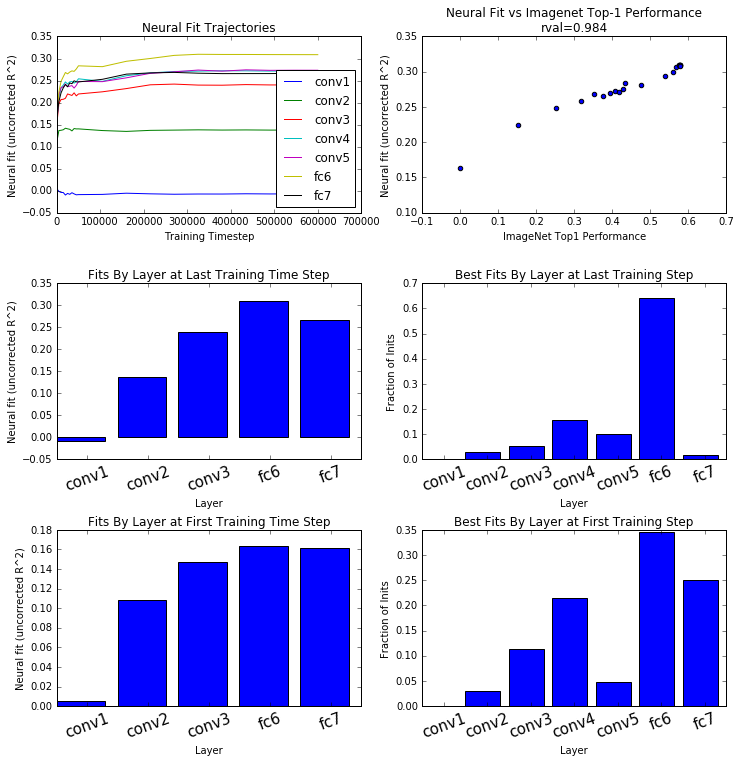

In [242]:
#now we'll plot some stuff

#first, let's plot neural fit as a function of training time
#and layer. 
fig = plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
lines = []
layer_list = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7']
layer_list1 = ['conv1', 'conv2', 'conv3', 'fc6', 'fc7']
for k in layer_list:
    lines.append(plt.plot(steps, pdict[k])[0])
plt.legend(lines, layer_list, loc='lower right')
plt.xlabel('Training Timestep')
plt.ylabel('Neural fit (uncorrected R^2)')
plt.title("Neural Fit Trajectories")

#next, let's plot -- for the best layer, fc6 -- the scatter of
#imagnet top1 performance vs neural fit
plt.subplot(3, 2, 2)
plt.scatter(perfs, pdict['fc6'])
rval = stats.pearsonr(perfs, pdict['fc6'])[0]
plt.xlabel('ImageNet Top1 Performance')
plt.ylabel('Neural fit (uncorrected R^2)')
plt.title('Neural Fit vs Imagenet Top-1 Performance\nrval=%.3f'% rval)

#for the last training step, let's look at neural fit by layer
plt.subplot(3, 2, 3)
yvals = [pdict[k][-1] for k in layer_list1]
plt.bar(range(len(layer_list1)), yvals)
plt.xticks(np.arange(len(layer_list1))+.5, layer_list1, rotation=20, fontsize=15);
plt.xlabel('Layer')
plt.ylabel('Neural fit (uncorrected R^2)')
plt.title('Fits By Layer at Last Training Time Step')

#and again, for the last training step, let's look at which layer best fits 
#each neuron, as a histogram across neurons
plt.subplot(3, 2, 4)
layer_max = np.array([np.array(pdict_array[k])[-1] for k in layer_list]).argmax(0)
counts = np.bincount(layer_max) 
yvals = counts / float(counts.sum())
plt.bar(range(len(layer_list)), yvals)
plt.xticks(np.arange(len(layer_list))+.5, layer_list, rotation=20, fontsize=15);
plt.xlabel('Layer')
plt.ylabel('Fraction of Inits')
plt.title('Best Fits By Layer at Last Training Step')

#same as plot 3 above, except for the initial (untrained) model
plt.subplot(3, 2, 5)
yvals = [pdict[k][0] for k in layer_list1]
plt.bar(range(len(layer_list1)), yvals)
plt.xticks(np.arange(len(layer_list1))+.5, layer_list1, rotation=20, fontsize=15);
plt.xlabel('Layer')
plt.ylabel('Neural fit (uncorrected R^2)')
plt.title('Fits By Layer at First Training Time Step')

#same as plot 4 above, except for the initial (untrained) model
plt.subplot(3, 2, 6)
layer_max = np.array([np.array(pdict_array[k])[0] for k in layer_list]).argmax(0)
counts = np.bincount(layer_max) 
yvals = counts / float(counts.sum())
plt.bar(range(len(layer_list)), yvals)
plt.xticks(np.arange(len(layer_list))+.5, layer_list, rotation=20, fontsize=15);
plt.xlabel('Layer')
plt.ylabel('Fraction of Inits')
plt.title('Best Fits By Layer at First Training Step')

plt.subplots_adjust(hspace=0.4)

### Reliability analysis

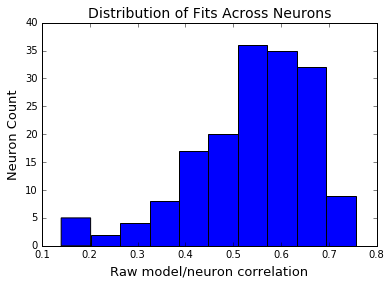

In [194]:
#let's get a histogram of neural fits across neurons
#different neurons are predicted differently well. 
#why?  
preds = np.array(pdict_array_corr['fc6'])[-1]

plt.hist(preds)
plt.xlabel('Raw model/neuron correlation', fontsize=13)
plt.ylabel('Neuron Count', fontsize=13)
plt.title('Distribution of Fits Across Neurons', fontsize=14)

In [243]:
#actually the reason has to do not with anything special about 
#badly predicted neurons -- it's just that they're data is less 
#reliably recorded. To see that, we'll compare predictivity to reliability
#on a per neuron basis. 

#first, let's get the trial-specific data so we can compute reliability
unique_var_levels = np.unique(var_level)
IT_Data_by_trial = {}
for vl in unique_var_levels:
    level_number = vl[-1]
    arr = Ventral_Dataset['time_averaged']['variation_level_%s' % level_number][:, :, IT_NEURONS]
    IT_Data_by_trial[vl] = arr.swapaxes(0, 1)
    
#now let's compute spearman-brown corrected split-half reliability 
#(as discussed in the previous tutorial)
import utils
reliabilities = []
for i in range(len(IT_NEURONS)):
    datas_by_trial = [IT_Data_by_trial['V3'][:, :, i].T, IT_Data_by_trial['V6'][:, :, i].T]
    num_splits = 10
    reliability = utils.split_half_correlation(datas_by_trial,
                           num_splits)
    reliabilities.append(reliability)
reliabilities = np.array(reliabilities).mean(axis=1)

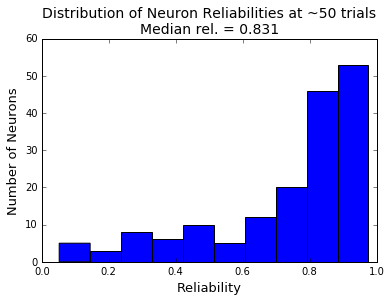

In [199]:
#let's plot the reliabilities
#obvious not all neurons are reliable, but mostly they're pretty good

plt.hist(reliabilities)
plt.xlabel('Reliability', fontsize=13)
plt.ylabel('Number of Neurons', fontsize=13)
meanrel = np.median(reliabilities)
plt.title('Distribution of Neuron Reliabilities at ~50 trials\nMedian rel. = %.3f' % meanrel, fontsize=14)

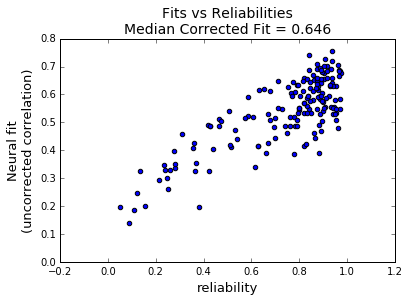

In [197]:
#now let's plot reliability vs neural predictivity
#using the correction formula discussed in the lecture

plt.scatter(reliabilities, preds)
plt.xlabel('reliability', fontsize=13)
plt.ylabel('Neural fit\n(uncorrected correlation)', fontsize=13)
corrected = preds / np.sqrt(reliabilities)
med_corrected = np.median(corrected)
plt.title('Fits vs Reliabilities\nMedian Corrected Fit = %.3f' % med_corrected, fontsize=14)